<a href="https://colab.research.google.com/github/khalil753/Bio-Project/blob/master/2_DirtyTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description of the Notebook**

In this notebook the first round of training, using the full training dataset, is performed. Afterwards, the trained model is used to calculate the loss of all of the training samples. Samples which have a loss above a given threshold (in this case 0.5) are tagged as dirty, while the rest are tagged as clean.


# **Instructions of use of the Notebook**

To make use of this notebook, only one modification needs to be made in the last cell of the "Mounting libraries and defining global variables" section: 

1-Modify the "path" variable: This variable should hold the path of the project file. All of the files created in this or other notebooks will be saved in this path.


After having modified the path variable, one may simple run the entire notebook.

# **Mounting libraries and defining global variables**

In [ ]:
import fastai
from fastai.vision import *
from fastai.widgets import *

import numpy as np
import pandas as pd

from pathlib import Path
import os
from os import listdir

import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

Before running the notebook one must modify the "path" variable. Uncomment the variable after having done the modification.

In [ ]:
#path = Path(r"Insert here the project file's path")
path_data = path/'data'
path_losses = path/"Performance Metrics"/"Losses"
path_models = path/"models"
path_model_1 = path_models/"Model 1"

classes = ['healthy', 'tumor', 'injury']

# **Training the model**

These are some flags that allow to prevent some parts of the notebook from running. For instance, if the variable training is set to false, when one runs the entire notebook the training of the model part won't be executed.

In [ ]:
finding_lr = True
training = True

## *Loading Data and Model*

Here one loads the data. In the fastai API this is done with the ImageDataBunch class. More info about this can be found in the [library's manual](https://docs.fast.ai/vision.data.html#ImageDataBunch) or in the [first video](https://course.fast.ai/videos/?lesson=1)  of the fastai course in which they make use of the data API.



In [ ]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_folder(path_data, ds_tfms=tfms, size=32,  
                                        train="train",
                                        valid="val",
                                        classes=classes, bs=100,
                                        num_workers=1).normalize(imagenet_stats)

Here one creates an instance of the "learner" class which groups the data and the neural net model (in this case a pretraiend resnet 18) in a single object. The class also contains methods to perform the training.

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, path=path_data)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## *Finding the best Learning Rate*

By default, fastai uses learning rate schedule developed in this [paper](https://arxiv.org/abs/1506.01186). Running the following two cells allows one to find a good threshold for the learning rate, as explained in the [first video](https://course.fast.ai/videos/?lesson=1) of the fastai course.

In [ ]:
if finding_lr:
  learn.lr_find()

In [ ]:
if finding_lr:
  learn.recorder.plot()

## *Training the fully connected layers of the NN*

Although the model we use is a pretrained resnet 18, an untrained fully connected layer must be placed at the tip/end of the resnet so that the model works given our size of input images and number of categories. The following cells train only this last fully connected tip and then save the obtained model.

In [ ]:
if training:
  learn.fit_one_cycle(15, max_lr=0.002)

In [ ]:
if training: learn.save(path_model_1/'stage-1')

## *Fine tuning the model*

the following cell trains the backbone of the resnet eg, the parts that precede the fully connected tip. This process is called fine tuning.

In [ ]:
if training: 
  learn.load(path_model_1/'stage-1')
  learn.unfreeze()
  learn.fit_one_cycle(10, max_lr=slice(3e-5,3e-4))

In [ ]:
if training: learn.save(path_model_1/'stage-2')

# **Studying the Losses**

Since the model with fine tuning performed better, we use the stage-2 model for calculating the losses

In [ ]:
if training:
  learn.load(path_model_1/'stage-2')

## *Calculating validation and training loss*

In [ ]:
calculating_losses = False

In [ ]:
if calculating_losses:
  val_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
  train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

In [ ]:
if calculating_losses:
  (val_losses, val_idxs), (train_losses, train_idxs) = val_interp.top_losses(), train_interp.top_losses()
  torch.save(train_losses, path_losses/'train_losses1.pt')
  torch.save(train_idxs, path_losses/'train_idxs1.pt')
  torch.save(val_losses, path_losses/'val_losses1.pt')
  torch.save(val_idxs, path_losses/'val_idxs1.pt')

## *Saving Predictions and Confusion Matrix*

We save the predictions to not have to recalculate them PerformanceEval notebook

In [ ]:
if calculating_losses:
  cm = val_interp.confusion_matrix()
  preds = val_interp.preds
  np.save(path/"Performance Metrics"/"Confusion Matrices"/"CM1", cm)
  np.save(path/"Performance Metrics"/"Preds"/"p1", preds)

## *Plotting Loss Histograms*

In [ ]:
train_losses = torch.load(path_losses/'train_losses1.pt')
val_losses = torch.load(path_losses/'val_losses1.pt')
losses = [train_losses, val_losses]

train_idxs = torch.load(path_losses/'train_idxs1.pt')
val_idxs = torch.load(path_losses/'val_idxs1.pt')
losses = [train_losses, val_losses]
idxs = [train_idxs, val_idxs]

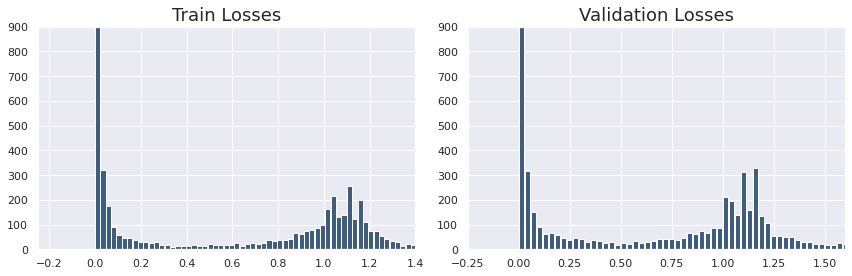

In [ ]:
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

xlims = [(-0.25,1.4), (-.25, 1.6)]
names = ["Train", "Validation"]
bins = [190, 300]
for name, loss, axis, xlim, b in zip(names, losses, ax, xlims, bins):
  axis.set_xlim(*xlim)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  hist = axis.hist(loss, bins=b, color="#3F5D7D", rwidth=.95)  
plt.tight_layout()
plt.show()
fig.savefig(path/"figs"/"Loss_Hist1.png")

## *Tagging high loss images*

Fastai allows to save the datasets as a pandas dataframe.Said dataframe contains a row per each sample and normally contains two columns, one which specifies the path in which the sample (in this case an image of the cell) is saved, and another which contains the class of the sample. A third column column called "clean" was added to the dataframe, to tag the samples with high loss; samples with a loss above (below) the selected threshold have a value of False (True) in the "clean" column.


clean train: 9571/12335 = 78%
clean val: 4917/7308 = 67%


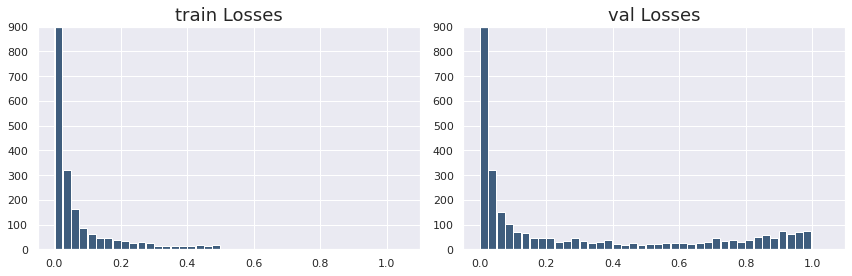

In [ ]:
dfs = [data.train_ds.to_df(), data.valid_ds.to_df()]
thresholds = [.5, 1]
names = ["train", "val"]
is_valid = ["False", "True"]
bins = [20, 40]
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

for loss, idx, th, df, name, is_val, axis, b  in zip(losses, idxs, thresholds, dfs, names, is_valid, ax, bins):
  # Defining the "is_valid" column to define ImageLists from df in CleanTraining
  df["is_valid"] = is_val

  # Adding a column clean to indicate the low loss samples
  n_good = (loss <= th).sum()
  good_idx = idx[-n_good:]
  clean = np.zeros(len(df), dtype=bool)
  clean[good_idx] = True
  p = float(n_good)/len(df)*100
  print(f"clean {name}: {n_good}/{len(df)} = {p:0.0f}%")
  df["clean"] = clean
  df.to_csv(path_data/"Clean Data"/f"{name}.csv", index=False)

  # Plotting hists of low loss images
  axis.set_xlim(-0.05, 1.1)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  hist = axis.hist(loss[-n_good:], bins=b, color="#3F5D7D", rwidth=.95)  

plt.tight_layout()
plt.show()